In [1]:
%matplotlib inline

import gci
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd

In [2]:
pd.set_option('display.width', None)
pd.set_option('display.max_columns', 10)

style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
DEFAULT_PRECISION = np.float128(0.000001)
TRANSFORMATIONS = [('divide_xis', {'min_num_parts': 1, 'max_num_parts': 6})]

In [4]:
def get_I(k, i):
    assert k >= 0
    assert 1 >= i >= 0
    if k == 1:
        return i
    else:
        k = np.float128(k)
        i = np.float128(i)
        return (pow(k, i) - 1) / (k-1)

def get_i(k, I):
    assert k >= 0
    assert 1 >= I >= 0
    if k == 1:
        return I
    else:
        k = np.float128(k)
        I = np.float128(I)
        return np.log(I * (k - 1) + 1) / np.log(k)

def get_mean_i(dfxi, k, row1, row2, col):
    assert k >= 0
    k = np.float128(k)
    sum_mean_i = np.float128(0)
    xi_1 = np.float128(dfxi[col][row1])
    xi_2 = np.float128(dfxi[col][row2])
    for row_index in range(row1, row2 + 1):
        xi = (np.float128(dfxi[col][row_index]) - xi_1) / (xi_2 - xi_1)
        mean_i = np.float128((pow(k, xi) - 1) / (k-1))
        sum_mean_i += mean_i
    return sum_mean_i / (row2 + 1 - row1)

def getk50(dfxi, col=None, row1=None, row2=None, precision=DEFAULT_PRECISION):
    col = col or dfxi.columns[0]
    row1 = row1 or 0
    row2 = row2 or len(dfxi) -1
    precision = precision or DEFAULT_PRECISION
    k1 = np.float128(0.999)
    k2 = np.float128(1.001)
    precision = precision
    mean_i_1 = get_mean_i(dfxi, k1, row1, row2, col)
    mean_i_2 = get_mean_i(dfxi, k2, row1, row2, col)
    if mean_i_1 < mean_i_2:
        if mean_i_1 > np.float128(0.5):
            k1 = np.float128(0.00000001)
            k2 = np.float128(0.99999999)
        elif mean_i_2 < np.float128(0.5):
            k1 = np.float128(1.00000001)
            k2 = np.float128(99999999)
        else:
            raise Exception(mean_i_1, mean_i_2)
    else:
        if mean_i_2 > np.float128(0.5):
            k1 = np.float128(1.00000001)
            k2 = np.float128(99999999)
        elif mean_i_1 < np.float128(0.5):
            k1 = np.float128(0.00000001)
            k2 = np.float128(0.99999999)
        else:
            raise Exception(mean_i_1, mean_i_2)
    mean_i_1 = get_mean_i(dfxi, k1, row1, row2, col)
    mean_i_2 = get_mean_i(dfxi, k2, row1, row2, col)
    while abs(k2 - k1) > precision:
        if abs(mean_i_1 - np.float128(0.5)) < precision:
            return (k1, mean_i_1, 1)
        if abs(mean_i_2 - np.float128(0.5)) < precision:
            return (k2, mean_i_2, 2)
        k3 = (k1 + k2) / 2
        mean_i_3 = get_mean_i(dfxi, k3, row1, row2, col)
        if abs(mean_i_3 - np.float128(0.5)) < precision:
            return (k3, mean_i_3, 3)
        if mean_i_2 > mean_i_1:
            if mean_i_3 > np.float128(0.5):
                k2 = k3
                mean_i_2 = mean_i_3 
            else:
                k1 = k3
                mean_i_1 = mean_i_3 
        else:  
            if mean_i_3 > np.float128(0.5):
                k1 = k3
                mean_i_1 = mean_i_3 
            else:
                k2 = k3
                mean_i_2 = mean_i_3 
    return (k3, mean_i_3, 4)

def get_k_by_parts(dfxs, dfxi, dfxor, num_parts=4, precision=DEFAULT_PRECISION):
    precision = precision or DEFAULT_PRECISION
    dfxt = pd.DataFrame(index=dfxs.index, columns=['xt_' + str(col) for col in dfxi.columns])
    dfxot = dfxs.copy()
    for col in dfxs.columns:
        dfxot['xt_' + str(col)] = np.nan
    parts = np.array_split(np.array(dfxot.index), num_parts)
    for part in parts:
        row1 = part[0]
        row2 = part[-1]
        for col in dfxi.columns:
            value_min = dfxi[col][row1]
            value_max = dfxi[col][row2]
            k, mean_i, case = getk50(dfxi, col, row1, row2, precision)
            for row in range(row1, row2 + 1):
                value = dfxi[col][row]
                transformed_value = transform_value(value, value_min, value_max, k)
                dfxt['xt_' + str(col)].set_value(row, transformed_value)
                dfxot['xt_' + str(col)].set_value(dfxor[col][row], transformed_value)
    return dfxt, dfxot

def transform_value(value, value_min, value_max, k):
    exponent = (value - value_min) / (value_max - value_min)
    return (value_min + ((value_max - value_min) * (pow(k, exponent) - 1) / (k - 1)))


In [5]:
def get_xor(dfxs):
    dfxor = pd.DataFrame()
    dfxr = pd.DataFrame()
    for ix in dfxs:
        vals = dfxs[ix].sort_values().reset_index()
        dfxor[ix] = vals['index']
        dfxr[ix] = vals[ix]
    return dfxor, dfxr

In [6]:
def get_xi(dfxs):
    dfxor, dfxr = get_xor(dfxs)
    dfxi = dfxs.copy()
    for col in dfxr.columns:
        _min = dfxr[col].min()
        _max = dfxr[col].max()
        dfxi[col] = dfxr.apply(lambda row: (row[col] - _min) / (_max - _min), axis=1).astype('float128')
    return dfxi, dfxor, dfxr

In [7]:
def divide_xis(dfxs, min_num_parts, max_num_parts):
    dfxts = {}
    dfxots = {}
    dfxi, dfxor, dfxr = get_xi(dfxs)
    for num_parts in range(min_num_parts, max_num_parts + 1):
        dfxt, dfxot = get_k_by_parts(dfxs, dfxi, dfxor, num_parts)
        dfxts[num_parts] = dfxt
        dfxots[num_parts] = dfxot
    return dfxts, dfxots

In [8]:
def get_xots(dfxs):
    dfxts = {}
    dfxots = {}
    for transformation, params in TRANSFORMATIONS:
        _dfxts, _dfxots = globals()[transformation](dfxs, **params)
        dfxts.update(_dfxts)
        dfxots.update(_dfxots)
    return dfxts, dfxots

In [9]:
def xs_from_xo(dfxo):
    return dfxo.reset_index(drop=True).rename(columns={j:i for i, j in enumerate(dfxo.columns)})

In [24]:
def plot_transformations(dfxo):
    dfxs = xs_from_xo(dfxo)
    dfxts, dfxots = get_xots(dfxs)
    plt.close('all')
    num_rows = np.ceil((len(dfxots) + 1) / 2)
    iii = 1
    for key, dfxot in dfxots.items():
        if iii == 1:
            sp = plt.subplot(num_rows, 2, 1)
            sp.plot([dfxot[0].min(), dfxot[0].max()], [dfxot[0].min(), dfxot[0].max()], 'bs-')
            sp.plot(dfxot[0], dfxot[1], 'ro')
            sp.set_title('Original data')
            sp.set_xlabel(dfxo.iloc[0].index[0])
            sp.set_ylabel(dfxo.iloc[0].index[1])
        iii += 1
        sp = plt.subplot(num_rows, 2, iii)
        sp.plot([0, 1], [0, 1], 'bs-')
        sp.plot(dfxot['xt_0'], dfxot['xt_1'], 'ro')
        sp.set_title('with xo divided in ' + str(key))
        sp.set_xlabel(dfxo.iloc[0].index[0])
        sp.set_ylabel(dfxo.iloc[0].index[1])
    sp.figure.set_size_inches(20, num_rows * 10)
    return sp.figure, dfxots

In [11]:
def get_best_transformation(dfxots):
    highest_correlation = 0
    best_transformation = None
    for key, dfxot in dfxots.items():
        if best_transformation is None:
            xt_diff = abs(dfxot[0] - dfxot[1]).sum()
            xt_sum = abs(dfxot[0] + dfxot[1] - 1).sum()
            correlation = 1 - xt_diff / xt_sum
            print("original data: ", correlation, ((xt_sum - xt_diff) / (xt_sum + xt_diff) ))
        xt_diff = abs(dfxot['xt_0'] - dfxot['xt_1']).sum()
        xt_sum = abs(dfxot['xt_0'] + dfxot['xt_1'] - 1).sum()
        correlation = 1 - xt_diff / xt_sum
        print("xo / {}: ".format(str(key)), correlation, ((xt_sum - xt_diff) / (xt_sum + xt_diff) ))
        if correlation > highest_correlation:
            highest_correlation = correlation
            best_transformation = key
    return best_transformation, dfxots[best_transformation]

In [40]:
def plot_transformation(dfxot):
    fig2, ((sp21, sp22), (sp23, sp24)) = plt.subplots(2, 2)
    fig2.set_size_inches(20, 20)
    sp21.plot(dfxot[0], dfxot[1], 'ro')
    sp21.plot([dfxot[0].min(), dfxot[0].max()], [dfxot[0].min(), dfxot[0].max()], 'bs-')
    sp21.set_xlabel(dfxo.iloc[0].index[0])
    sp21.set_ylabel(dfxo.iloc[0].index[1])
    sp21.set_title('Original data')
    sp22.plot(dfxot['xt_1'], dfxot[1], 'ro')
    sp22.set_title(dfxo.iloc[0].index[1])
    sp22.set_xlabel('Transformed data')
    sp22.set_ylabel('Original data')
    sp23.plot(dfxot[0], dfxot['xt_0'], 'ro')
    sp23.set_title(dfxo.iloc[0].index[0])
    sp23.set_xlabel('Original data')
    sp23.set_ylabel('Transformed data')
    sp24.plot([0, 1], [0, 1], 'bs-')
    sp24.plot(dfxot['xt_1'], dfxot['xt_0'], 'ro')
    sp24.set_title('Transformed data')
    sp24.set_xlabel(dfxo.iloc[0].index[1])
    sp24.set_ylabel(dfxo.iloc[0].index[0])
    return fig2

====================================================================================================================

In [13]:
dfxo = gci.get_indicators(['GCI.A.02.02.01', 'GCI.A.02.01.01'], '2015-2016')
# dfxo = pd.read_csv('../../data/test_data.tsv', sep="\t")

====================================================================================================================

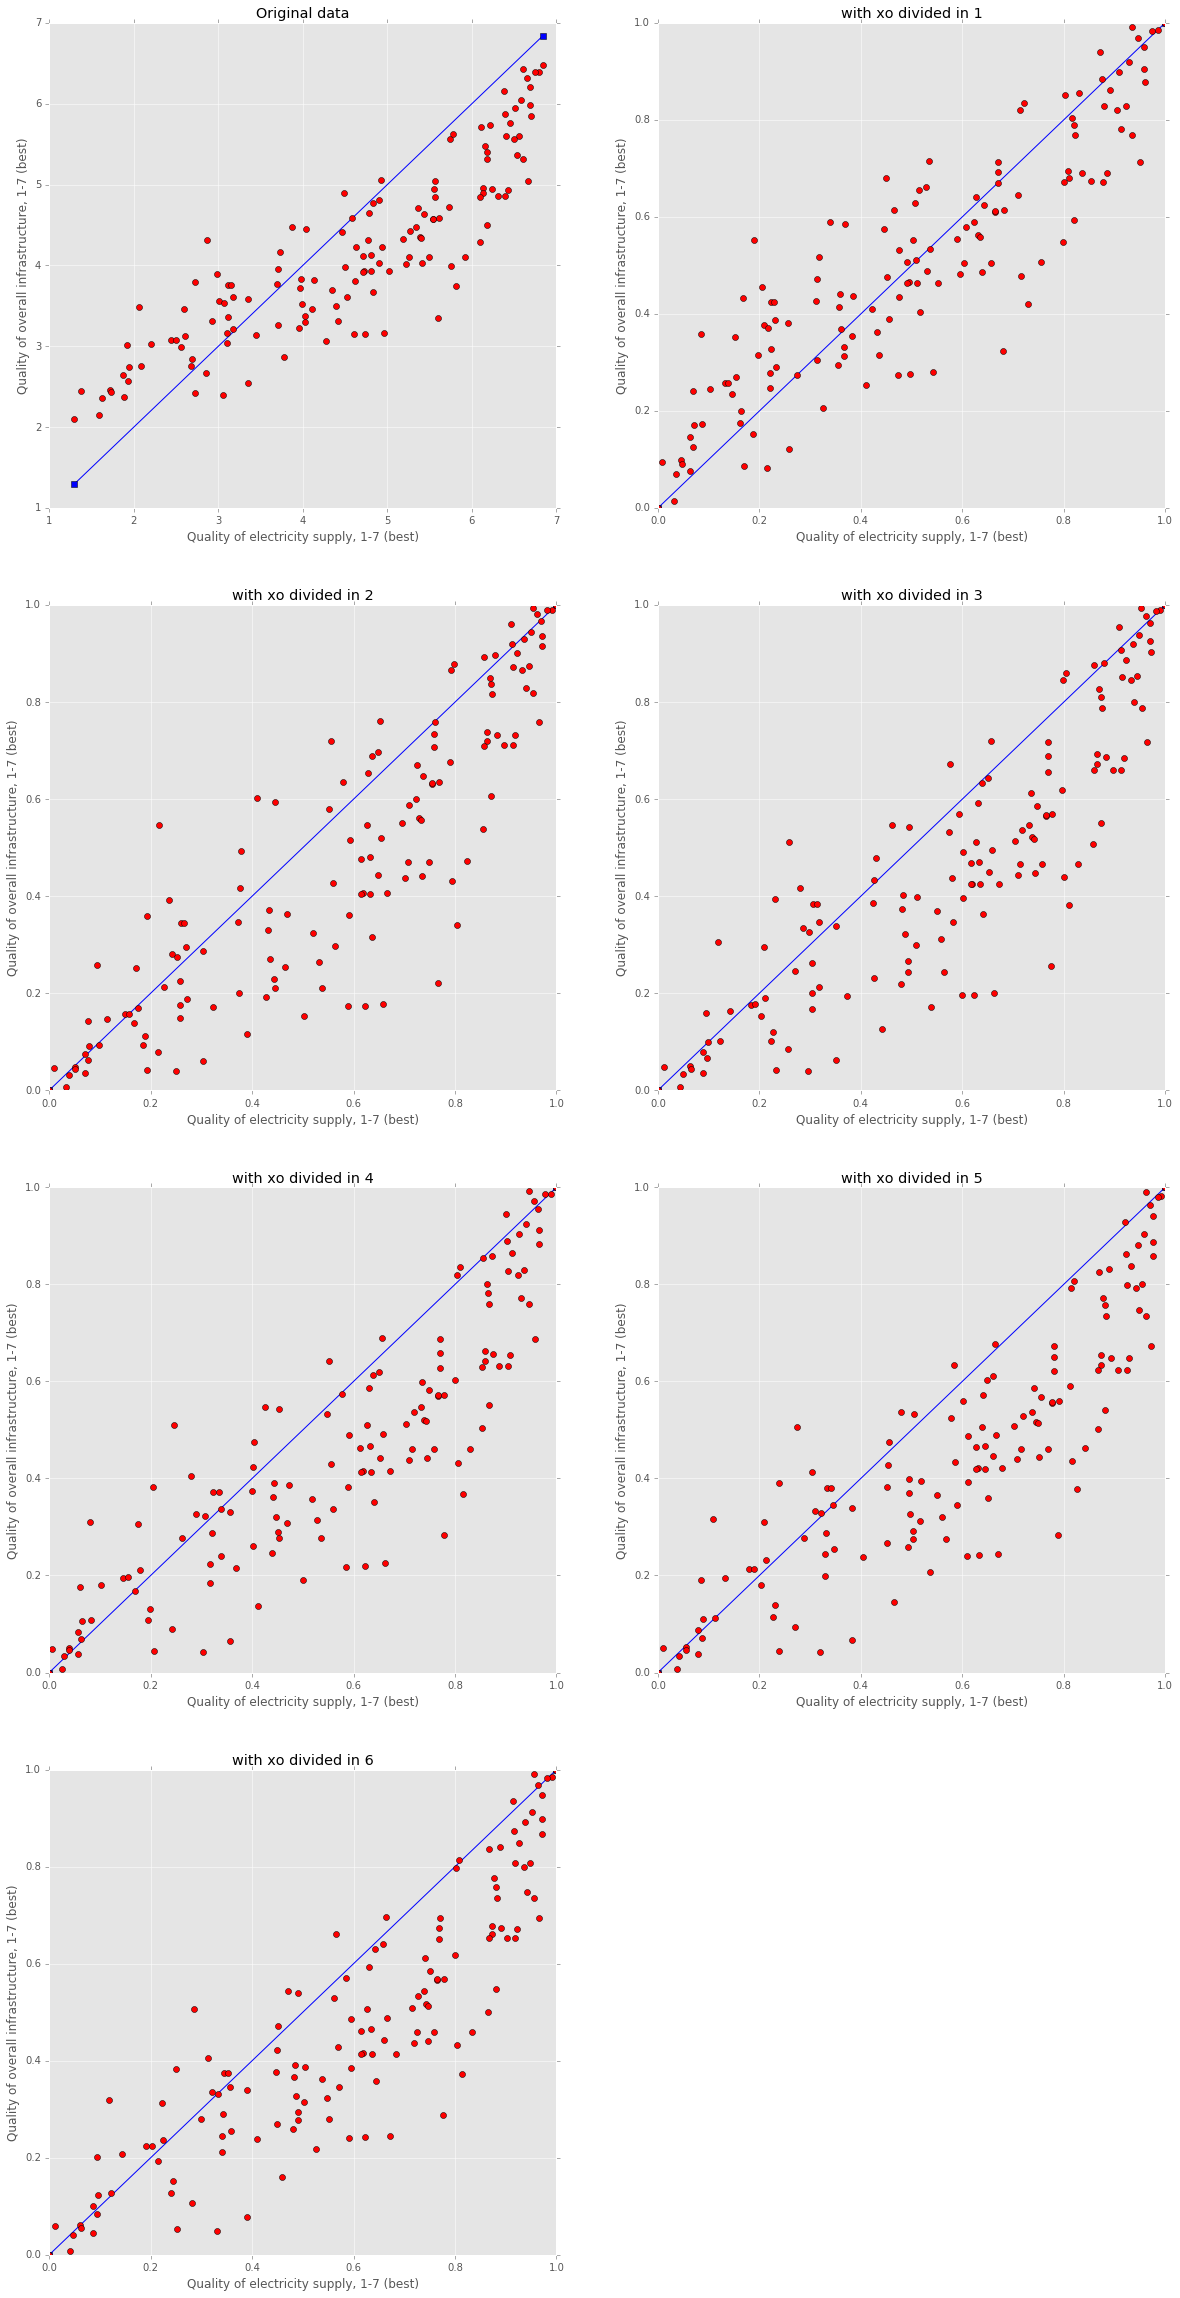

In [25]:
fig1, dfxots = plot_transformations(dfxo)

In [15]:
best_transformation, dfxot = get_best_transformation(dfxots)

original data:  0.901797109033 0.82115710717
xo / 1:  0.7688482644012423 0.6244951309980659
xo / 2:  0.7383455911794272 0.5852201569759915
xo / 3:  0.6949710602671932 0.5325330642931815
xo / 4:  0.695515926647262 0.533173183831729
xo / 5:  0.6566622280106051 0.48882882749446677
xo / 6:  0.6737239023215928 0.5079816363281517


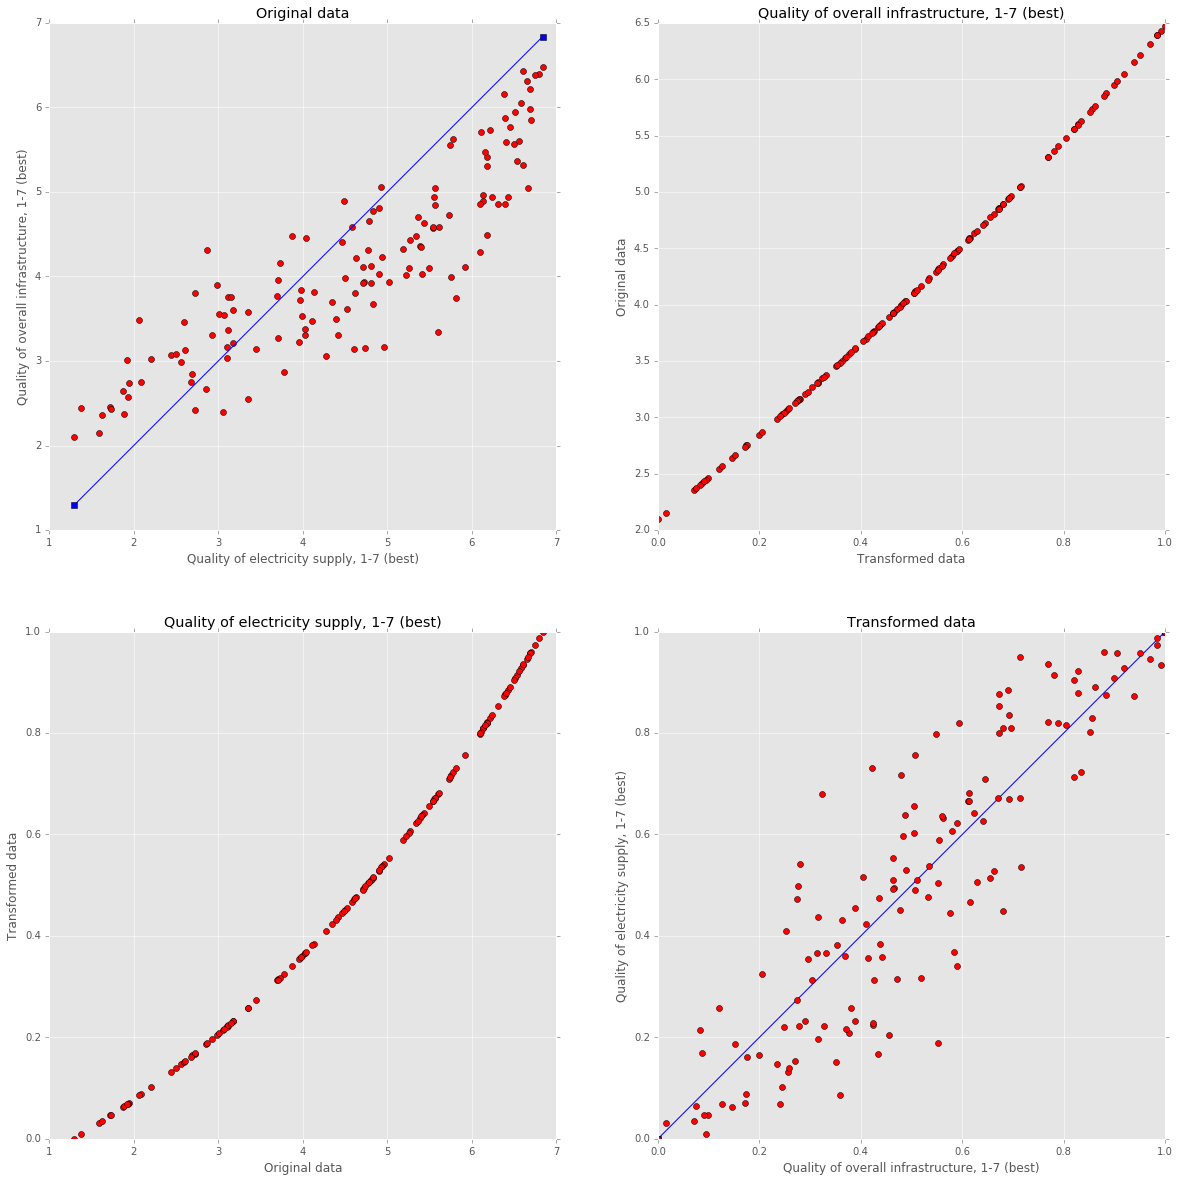

In [41]:
fig2 = plot_transformation(dfxot)

====================================================================================================================

In [17]:
dfxs = xs_from_xo(dfxo)
dfxs.dtypes

0    float128
1    float128
dtype: object

In [18]:
dfxor, dfxr = get_xor(dfxs)
dfxor.dtypes

0    int64
1    int64
dtype: object

In [19]:
dfxr.dtypes

0    float128
1    float128
dtype: object

In [20]:
dfxi = dfxs.copy()
for col in dfxr.columns:
    _min = dfxr[col].min()
    _max = dfxr[col].max()
    dfxi[col] = dfxr.apply(lambda row: (row[col] - _min) / (_max - _min), axis=1).astype('float128')


In [21]:
dfxi.dtypes

0    float128
1    float128
dtype: object